# Version Updates

- More readable plots
- More readable code
- Figure out where to slice dataframe [40:200]

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
res = requests.get(url, allow_redirects=True)
with open('time_series_covid19_confirmed_global.csv','wb') as file:
    file.write(res.content)
    
glob_data = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [31]:
us_data = glob_data[glob_data['Country/Region'] == 'US']
us_cases = us_data.values.tolist()[0][4:]   # 1/22/20 start

In [32]:
us_df = pd.DataFrame()
us_df['Infected'] = us_cases
days = np.arange(0,len(us_df['Infected'])).tolist()
us_df['Day'] = days 
us_df['New Infected'] =  us_df['Infected'] - us_df['Infected'].shift(1)
us_df['New Infected'].iloc[0] = 1
us_df = us_df[0:100]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


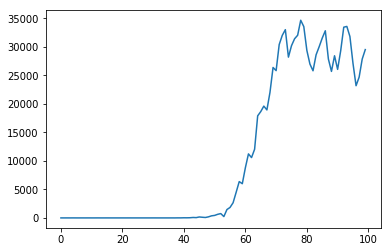

In [33]:
plt.plot(us_df['Day'], us_df['New Infected'])


In [37]:
def I_model(t, k, gamma, pop): # Dont fit gamma
    xplot=[0]
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-3]  # N-3 initially susceptible
    R = [0] # 0 recovered initially
    D = [0] # initial deaths
    deathrate = 0.0257046941 # global deathrate
    for i in t:
        x = xplot[i]
        
        
        kS1 = -k*S[i]*I[i]/N      
        kI1 = k*S[i]*I[i]/N - gamma*I[i] 
        kR1 = gamma*I[i]
        
        yS = S[i] + h*kS1
        yI = I[i] + h*kI1
        yR = R[i] + h*kR1
        
        xplot.append(x+h)
        S.append(yS)
        I.append(yI)
        R.append(yR)   # Removed ~ 
        
    return I[:-1]


def S_model(t, k, gamma, pop): # Dont fit gamma
    xplot=[0]
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-3]  # N-3 initially susceptible
    R = [0] # 0 recovered initially
    D = [0] # initial deaths
    deathrate = 0.0257046941 # global deathrate
    for i in t:
        x = xplot[i]
        
        
        kS1 = -k*S[i]*I[i]/N      
        kI1 = k*S[i]*I[i]/N - gamma*I[i] 
        kR1 = gamma*I[i]
        
        yS = S[i] + h*kS1
        yI = I[i] + h*kI1
        yR = R[i] + h*kR1
        
        xplot.append(x+h)
        S.append(yS)
        I.append(yI)
        R.append(yR)   # Removed ~ 
        
    return S[:-1]

def R_model(t, k, gamma, pop): # Dont fit gamma
    xplot=[0]
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-3]  # N-3 initially susceptible
    R = [0] # 0 recovered initially
    D = [0] # initial deaths
    deathrate = 0.0257046941 # global deathrate
    for i in t:
        x = xplot[i]
        
        
        kS1 = -k*S[i]*I[i]/N      
        kI1 = k*S[i]*I[i]/N - gamma*I[i] 
        kR1 = gamma*I[i]
        
        yS = S[i] + h*kS1
        yI = I[i] + h*kI1
        yR = R[i] + h*kR1
        
        xplot.append(x+h)
        S.append(yS)
        I.append(yI)
        R.append(yR)   # Removed ~ 
        
    return R[:-1]

Text(0.5, 0, 'Days')

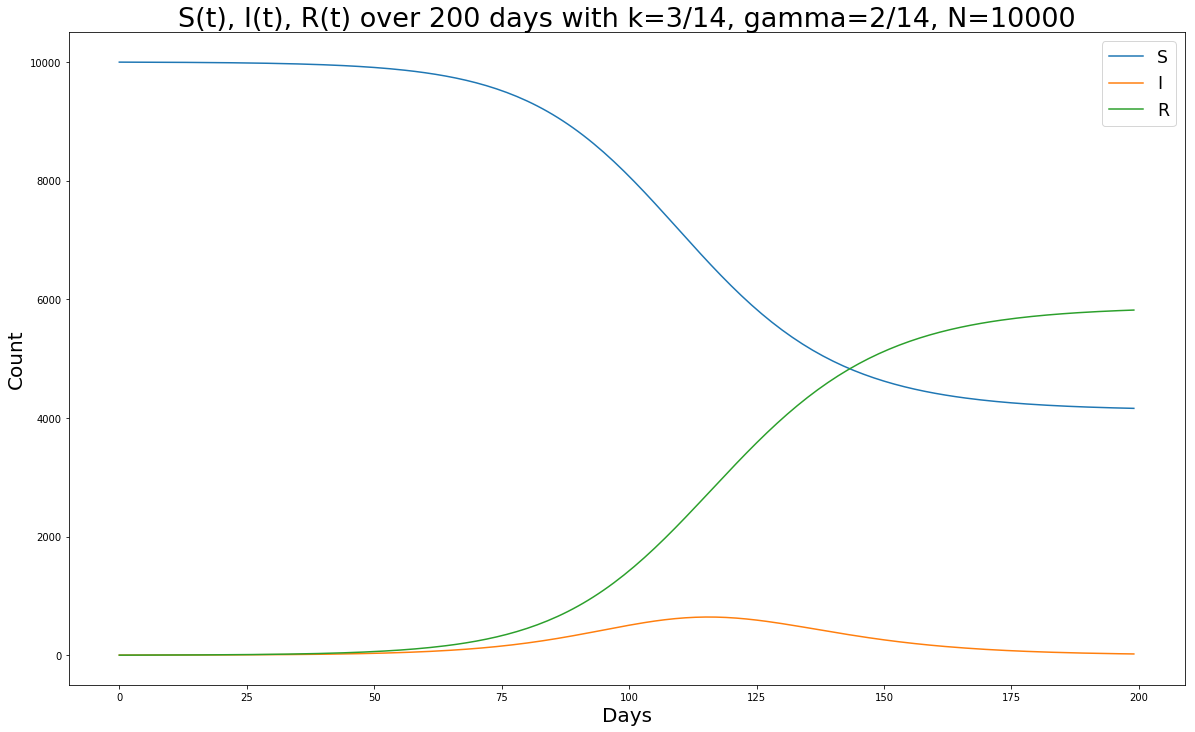

In [50]:
plt.figure(figsize=(20,12))
plt.plot(range(0,200),S_model(range(0,200), 3/14, 2/14, 10000), label="S")
plt.plot(range(0,200),I_model(range(0,200), 3/14, 2/14, 10000), label="I")
plt.plot(range(0,200),R_model(range(0,200), 3/14, 2/14, 10000), label="R")
plt.title("S(t), I(t), R(t) over 200 days with k=3/14, gamma=2/14, N=10000", size=27)
plt.legend(loc='best')
plt.legend(fontsize="xx-large")
plt.ylabel('Count', fontsize=20)
plt.xlabel('Days', fontsize=20)

N = 45820.5692183592 +/- 3262.512314788672
US: Best values for k:  0.1897 +/- 0.0029
US: Best values for gamma:  0.018 +/- 0.004
US: mean squared error between fit and data: 4332548.542131695
US: chi squared error between fit and data: Power_divergenceResult(statistic=43802.27689740168, pvalue=0.0)


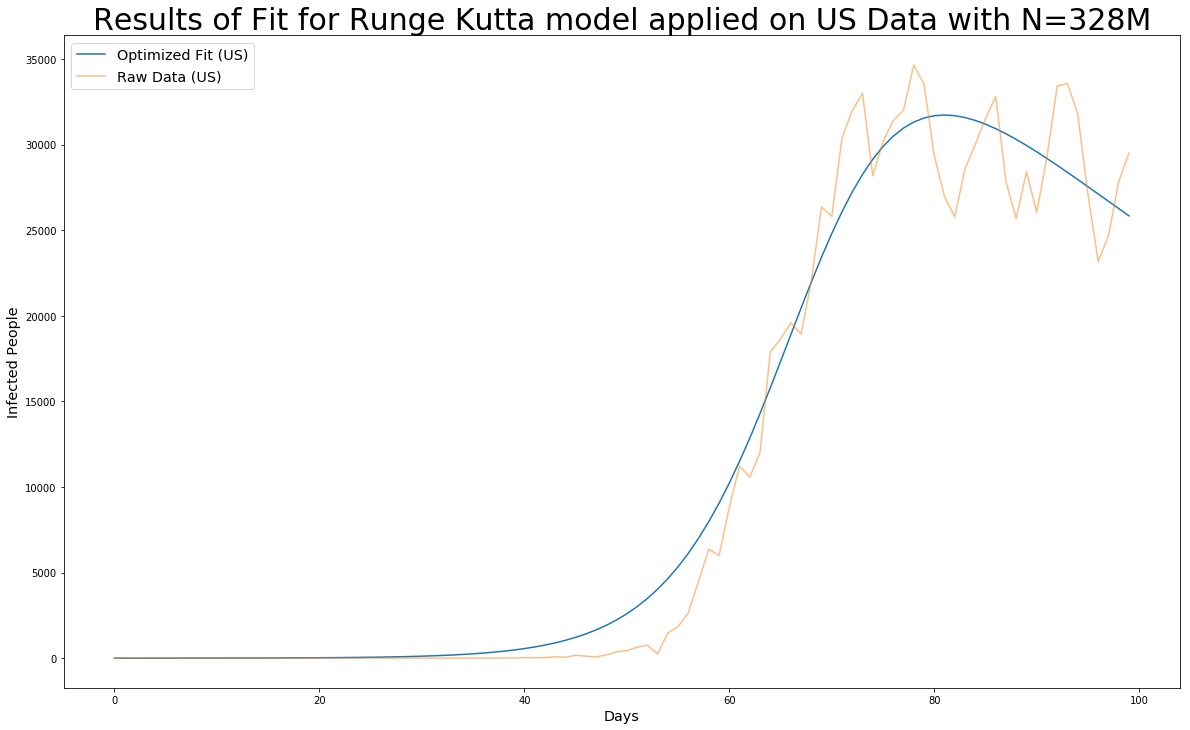

In [34]:
from scipy.optimize import curve_fit   # our main fitting optimizer (reduces error while finding best fit)
from scipy import optimize
from sklearn.metrics import mean_squared_error
from scipy import stats

par, cov = optimize.curve_fit(I_model, us_df['Day'], us_df['New Infected'], 
                                               p0=[2/14, 0.01, 328000000], bounds=(0, [100, 100, 328000000]), maxfev=5000)

pred1= I_model(us_df['Day'], par[0], par[1], par[2])
target1=us_df['New Infected']
print("N =", par[2], "+/-", (np.sqrt(np.diag(cov))[2]))
y1= mean_squared_error(target1, pred1)



print("US: Best values for k: ", round(par[0],4), "+/-", round(np.sqrt(np.diag(cov))[0],4))
print("US: Best values for gamma: ", round(par[1],4), "+/-", round(np.sqrt(np.diag(cov))[1],3))

print("US: mean squared error between fit and data:", y1)
chi1 = stats.chisquare(f_obs = target1, f_exp = pred1)
print("US: chi squared error between fit and data:", chi1)


plt.figure(figsize=(20,12))
plt.plot(us_df['Day'], pred1, label="Optimized Fit (US)", alpha=1.0)     # 
plt.plot(us_df['Day'], us_df['New Infected'], label='Raw Data (US)', alpha = 0.5)   # Raw US Data
 
plt.title("Results of Fit for Runge Kutta model applied on US Data with N=328M", fontsize=30)
plt.xlabel("Days", fontsize = "x-large")
plt.ylabel("Infected People", fontsize = "x-large")
plt.legend(loc='best')
plt.legend(fontsize="x-large")

plt.show()

# Notice that the fit overshoots the 1st 40 days a lot.
### Add a parameter that reduces the amplitude of I(t) if t -> [0,40]

# first play around with model, then try to guess a factor of 1/c * I(t)
- c represents a lack of initial tramission or spread

In [35]:
def I_model_2(t, k, gamma, c, pop): # Dont fit gamma
    xplot=[0]
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-3]  # N-3 initially susceptible
    R = [0] # 0 recovered initially
    D = [0] # initial deaths
    deathrate = 0.0257046941 # global deathrate
    for i in t:
        if i<40 and i>=0:
           
            x = xplot[i]
        
        
            kS1 = -k*S[i]*I[i]/N      
            kI1 = k*S[i]*I[i]/N - gamma*I[i] 
            kR1 = gamma*I[i]
        
            yS = S[i] + h*kS1
            yI = (I[i] + h*kI1)*c   # We reduce infections with C<1 for the first 40 days
            yR = R[i] + h*kR1
        
            xplot.append(x+h)
            S.append(yS)
            I.append(yI)
            R.append(yR)   # Removed ~ 
    #        print("Decay","i=",i,"I=",yI)
        else:
            x = xplot[i]
        
        
            kS1 = -k*S[i]*I[i]/N      
            kI1 = k*S[i]*I[i]/N - gamma*I[i] 
            kR1 = gamma*I[i]
        
            yS = S[i] + h*kS1
            yI = (I[i] + h*kI1)
            yR = R[i] + h*kR1
        
            xplot.append(x+h)
            S.append(yS)
            I.append(yI)
            R.append(yR)   # Removed ~   
       #     print("reg","i=",i,"I=",yI)

    
    return I[:-1]

x = I_model_2(range(0,100), 2/14, 0.01, 0.995, 320000000)

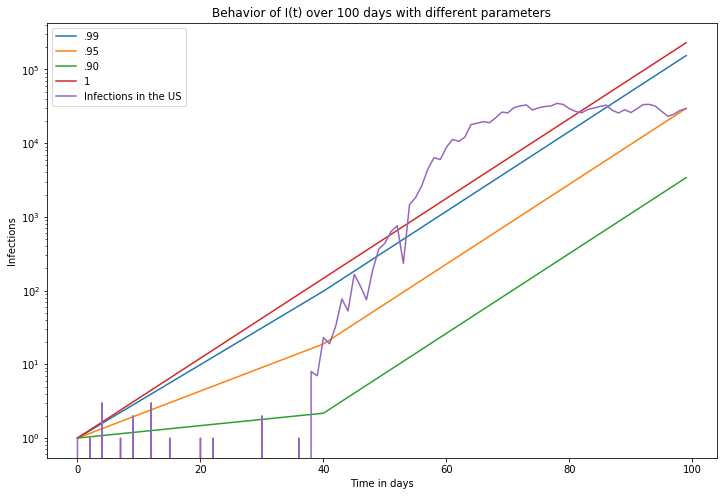

In [180]:
plt.figure(figsize=(12,8))

plt.plot(range(0,100), I_model_2(range(0,100),2/14, 0.01, 0.99,320000000), label=".99")
plt.plot(range(0,100), I_model_2(range(0,100),2/14, 0.01, 0.95,320000000), label=".95")
plt.plot(range(0,100), I_model_2(range(0,100),2/14, 0.01, 0.90,320000000), label=".90")
plt.plot(range(0,100), I_model_2(range(0,100),2/14, 0.01, 1,320000000), label="1")

plt.plot(us_df['Day'], us_df['New Infected'], label = "Infections in the US")
plt.yscale('log')
plt.ylabel("Infections")
plt.xlabel("Time in days")
plt.title('Behavior of I(t) over 100 days with different parameters')
plt.legend(loc='best')

N = 34680.05977753903 +/- 1419.5424184675844
US: Best values for k:  0.2891 +/- 0.0193
US: Best values for gamma:  0.0069 +/- 0.002
US: Best values for c:  0.8664 +/- 0.0219
US: mean squared error between fit and data: 2627114.4546191525
US: chi squared error between fit and data: Power_divergenceResult(statistic=13546.790995721482, pvalue=0.0)


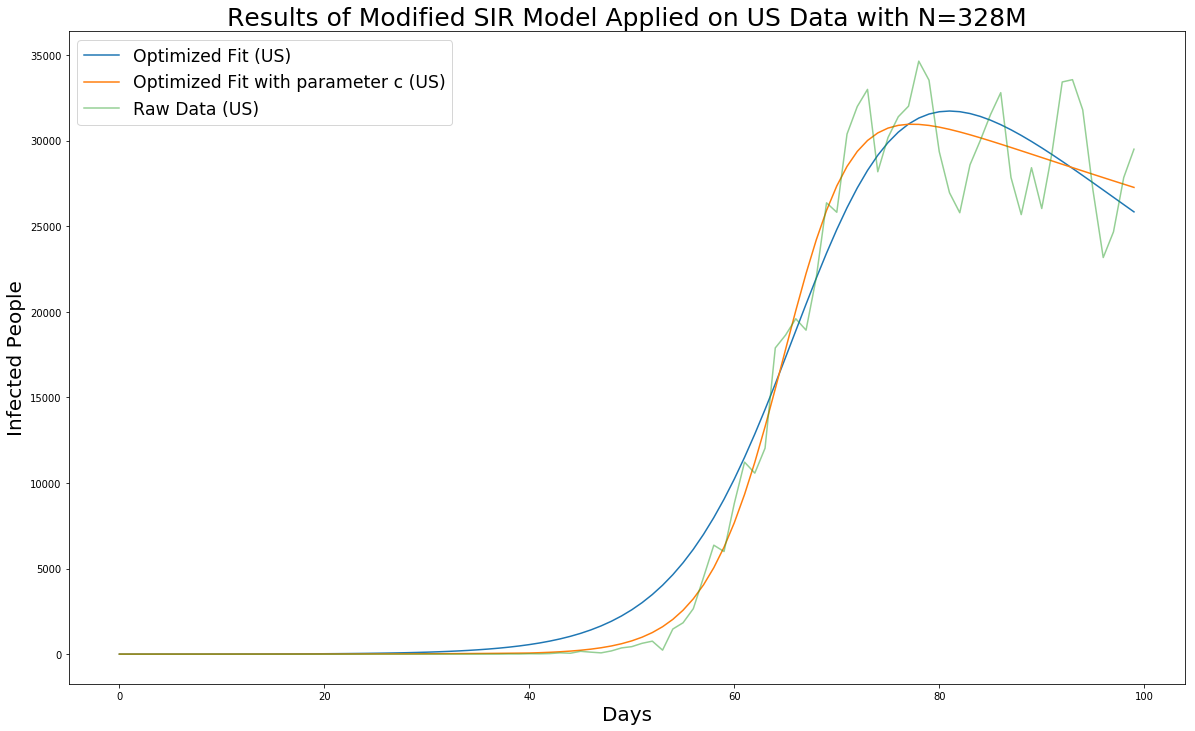

In [181]:
par2, cov2 = optimize.curve_fit(I_model_2, us_df['Day'], us_df['New Infected'], 
                                               p0=[2/14, 0.02, 0.995, 328000000], bounds=(0, [100, 100, 1, 328000000]), maxfev=5000)

pred2= I_model_2(us_df['Day'], par2[0], par2[1], par2[2], par2[3])
target2=us_df['New Infected']
print("N =", par2[3], "+/-", (np.sqrt(np.diag(cov2))[3]))
y2= mean_squared_error(target2, pred2)



print("US: Best values for k: ", round(par2[0],4), "+/-", round(np.sqrt(np.diag(cov2))[0],4))
print("US: Best values for gamma: ", round(par2[1],4), "+/-", round(np.sqrt(np.diag(cov2))[1],3))
print("US: Best values for c: ", round(par2[2],4), "+/-", round(np.sqrt(np.diag(cov2))[2],4))

print("US: mean squared error between fit and data:", y2)
chi2 = stats.chisquare(f_obs = target2, f_exp = pred2)
print("US: chi squared error between fit and data:", chi2)


plt.figure(figsize=(20,12))
plt.plot(us_df['Day'], pred1, label="Optimized Fit (US)", alpha=1.0)

plt.plot(us_df['Day'], pred2, label="Optimized Fit with parameter c (US)", alpha=1.0)

plt.plot(us_df['Day'], us_df['New Infected'], label='Raw Data (US)', alpha = 0.5)

plt.title("Results of Modified SIR Model Applied on US Data with N=328M", fontsize=25)
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Infected People", fontsize = 20)
plt.legend(loc='best')
#plt.yscale('log')
plt.legend(fontsize="xx-large")

plt.show()

# Plot the new prediction with bounds, and ask:
- Par contains array of parameters, np.sqrt(np.daig(cov)) contains standard deviations

In [182]:
upper_pred = I_model_2(us_df['Day'], par2[0]+np.sqrt(np.diag(cov2))[0], par2[1]+np.sqrt(np.diag(cov2))[1], 
                     par2[2]+np.sqrt(np.diag(cov2))[2], par2[3]+np.sqrt(np.diag(cov2))[3])
lower_pred = I_model_2(us_df['Day'], par2[0]-np.sqrt(np.diag(cov2))[0], par2[1]-np.sqrt(np.diag(cov2))[1], 
                     par2[2]-np.sqrt(np.diag(cov2))[2], par2[3]-np.sqrt(np.diag(cov2))[3])

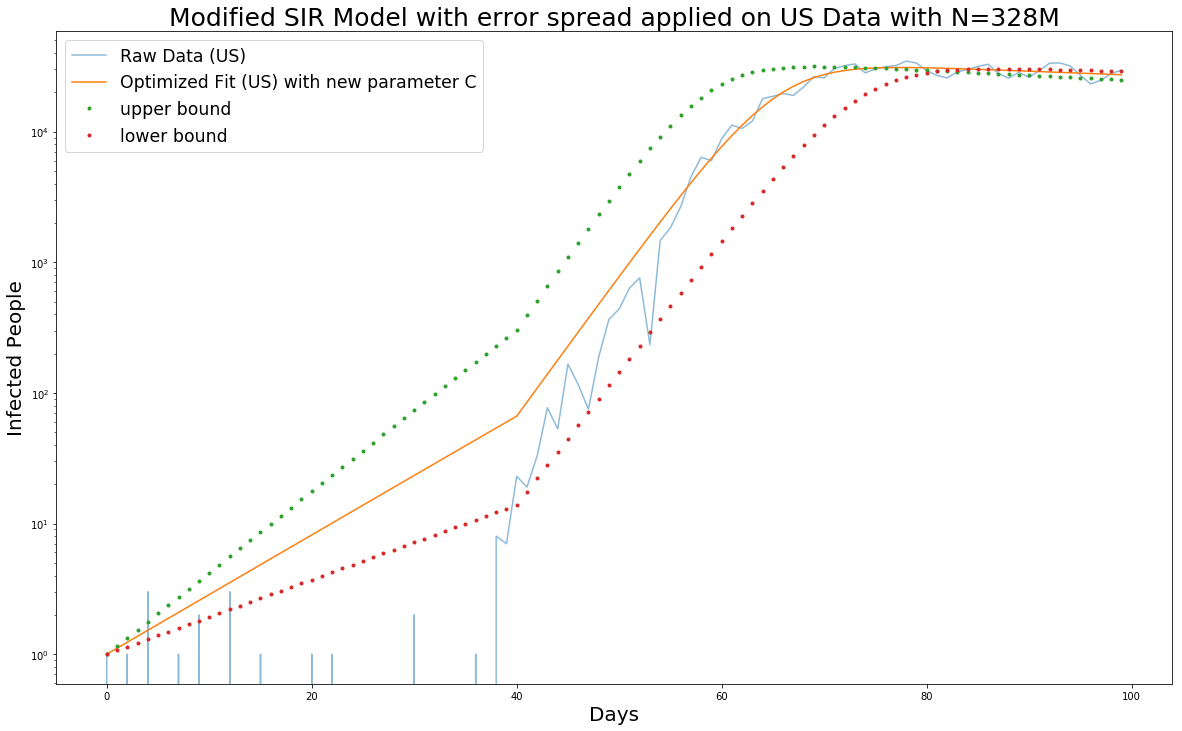

In [184]:
plt.figure(figsize=(20,12))
plt.plot(us_df['Day'], us_df['New Infected'], label='Raw Data (US)', alpha = 0.5)
plt.plot(us_df['Day'], pred2, label="Optimized Fit (US) with new parameter C", alpha=1.0)
plt.plot(us_df['Day'],upper_pred, '.', label='upper bound')
plt.plot(us_df['Day'],lower_pred, '.',label='lower bound')

plt.yscale('log')
plt.title("Modified SIR Model with error spread applied on US Data with N=328M", fontsize=25)
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Infected People", fontsize = 20)
plt.legend(loc='best')
plt.legend(fontsize="xx-large")

plt.show()